In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Constraints
#### Each stock < 15% of portfolio
#### Each industry < 40% of portfolio

In [2]:
df = pd.read_excel('Stock_Information.xlsx',header=None)
s1 = df.iloc[8,1:] # Stocks
s2 = df.iloc[9,1:] # Expected Return
s3 = df.iloc[10,1:] # Variance 

exp_return = np.array(s2) # Each row corresponds to a stock
var = np.array(s3)
corr = np.array(df.iloc[17:,1:])
exp_return = np.squeeze(exp_return.astype('float64'))
var = np.squeeze(var.astype('float64'))
corr = np.squeeze(corr.astype('float64'))

std_dev = np.diag(np.sqrt(var)) # Diagonal matrix of standard deviation
cov = np.matmul(std_dev,np.matmul(corr,std_dev)) # Covariance matrix

In [3]:
def portfolioReturn(wts,exp_return = exp_return): # Maximise
    return np.dot(wts,exp_return)

def portfolioRisk(wts,cov = cov): # Minimize (Check)
    arr1 = arr2 = wts
    arr1 = np.resize(arr1,(1,arr1.shape[0]))
    arr2 = np.resize(arr2,(arr2.shape[0],1))
    port_var = np.matmul(arr1,np.matmul(cov,arr2))
    port_var = np.squeeze(port_var)
    return port_var

def is_dominated(c1,c2): # Returns True if c2 dominates c1
    if(c2[0] > c1[0] and c2[1] < c1[1]):
        return True
    return False

def satisfies_constraints(wts): # Checks for constraints mentioned in problem statement.
    if wts is None:
        return False
    for i in range(len(wts)):
        if(wts[i]>0.15 or wts[i]<0):
            return False
    for i in range(0,len(wts)-4,4):
        if(wts[i]+wts[i+1]+wts[i+2]+wts[i+3]>0.4):
            return False
    if(sum(wts) != 1):
        return False
    c = compute_cost(wts)
    if(c[1]<0):
        return False
    return True

def compute_cost(pos):
    return np.array([portfolioReturn(pos),portfolioRisk(pos)])

def random_wts():
    wts = None
    while(not satisfies_constraints(wts)):
        wts = np.random.uniform(var_min,var_max,var_dim)
        wts = np.divide(wts,np.sum(wts))
    return wts

def nds(x,y):
    """
    Function that returns pareto fronts that maximise x and minimize y. Taken from last assignment.
    """
    assert len(y)==len(x)
    ranks = np.zeros(len(y))
    fronts = [[]]
    while(len(y)>0):
        indices = []
        for i in range(len(y)):
            flag = 0
            for j in range(len(y)):
                if(y[j]>y[i] and x[j]<x[i]):
                    flag = 1
                    break
            if(flag==0):
                fronts[-1].append((y[i],x[i]))
                indices.append(i)
        indices = sorted(indices,reverse=True)
        for i in indices:
            y.pop(i)
            x.pop(i)
        fronts.append([])
    return fronts[:-1]


In [4]:
class Particle(object): # Definition of particle
    def __init__(self,position):
        self.pos = position
        self.vel = np.zeros(position.shape)
        self.cost = self.compute_cost()
        self.best_pos = position
        self.best_cost = self.cost
        
    def compute_cost(self):
        return np.array([portfolioReturn(self.pos),portfolioRisk(self.pos)])

In [18]:
# Constants
var_min = 0
var_max = 0.15
var_dim = 20

max_iter = 100
pop_size = 100
w = 1 # Inertia Coefficient
w_damp = 0.99 # Damping coefficient
c1 = 2 # Personal Acceleration Coefficient
c2 = 2 # Social Acceleration Coefficient
directory = os.getcwd()

particle = [0]*pop_size # Initializing particles array

# Initialization
global_best = Particle(random_wts())
global_best.cost = np.array([np.NINF,np.inf])
for i in range(pop_size):
    particle[i] = Particle(random_wts())
    if(is_dominated(global_best.cost,particle[i].cost)):
        global_best.pos = particle[i].pos
        global_best.cost = particle[i].cost




# PSO iterations
for i in range(max_iter):
    costs = []
    for j in range(pop_size):
        new_vel = w*particle[j].vel + c1*np.random.rand(20)*(particle[j].best_pos - particle[j].pos) + c2*np.random.rand(20)*(global_best.pos - particle[j].pos)
        new_pos = particle[j].pos + new_vel
        new_pos = np.divide(new_pos,sum(new_pos)) # Normalisation
        if(satisfies_constraints(new_pos)):
            particle[j].vel = new_vel
            particle[j].pos = new_pos
            particle[j].cost = particle[j].compute_cost()
            if(is_dominated(particle[j].best_cost,particle[j].cost)): # Paritcle j dominates its personal best
                particle[j].best_pos = particle[j].pos
                particle[j].best_cost = particle[j].cost
        if(is_dominated(global_best.cost,particle[j].best_cost)): # Particle j dominates global best
            global_best.pos = particle[j].best_pos
            global_best.cost = particle[j].best_cost
        costs.append(particle[j].cost)
    # Plotting
    if(i%5==0):
        plt.figure()
        y = []
        x = []
        for k in range(len(costs)):
            y.append(costs[k][0])
            x.append(costs[k][1])
        plt.scatter(x,y,label='Other Particles')
        bests = nds(x.copy(),y.copy())[0]
        y_best = []
        x_best = []
        for k in range(len(bests)):
            y_best.append(bests[k][0])
            x_best.append(bests[k][1])
        plt.scatter(x_best,y_best,color='r',label='Best particles')
        plt.legend()
        plt.xlabel('Risk')
        plt.ylabel('Return (%)')
        plt.title("Risk v/s Return. Iteration = "+str(i))
#         plt.savefig("{}".format(i)+".png")
        plt.close()

Text(0.5, 1.0, 'Risk v/s Return. Iteration = 99')

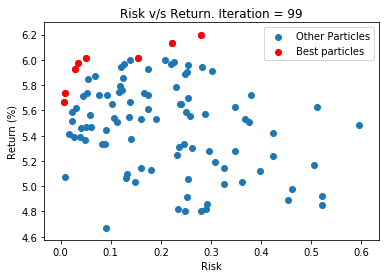

In [20]:
plt.figure()
plt.scatter(x,y,label='Other Particles')
plt.scatter(x_best,y_best,color='r',label='Best particles')
plt.legend()
plt.xlabel('Risk')
plt.ylabel('Return (%)')
plt.title("Risk v/s Return. Iteration = "+str(i))

In [25]:
print("One of the optimal solutions:")
print("Portfolio Weights in % = ",100*global_best.pos)
print("Return (%) =",global_best.cost[0])
print("Risk =",global_best.cost[1])
print("Do these weights satisfy the constraints -", satisfies_constraints(global_best.pos))

One of the optimal solutions:
Portfolio Weights in % =  [12.54281999  1.70996579  1.85738441  4.72019995  0.46593829  7.95363571
  5.33384295 13.69431704  1.03606766  2.66582961  3.46111848  4.37506893
  5.43596955  0.34328826  7.39701638  4.85949     0.4812174  13.81138902
  1.00461385  6.85082672]
Return (%) = 6.011325661709147
Risk = 0.05125938081214806
Do these weights satisfy the constraints - True
